# "Support Vector Machines: A Survey of its Applications with Special Emphasis on Facial Recognition Technology"
> "Introducing support vector machines while observing its use in the real world, with special consideration to facial recognition."

- toc: false
- branch: master
- badges: true
- comments: false
- math: true
- search_exclude: true
- categories: [fastpages, jupyter]

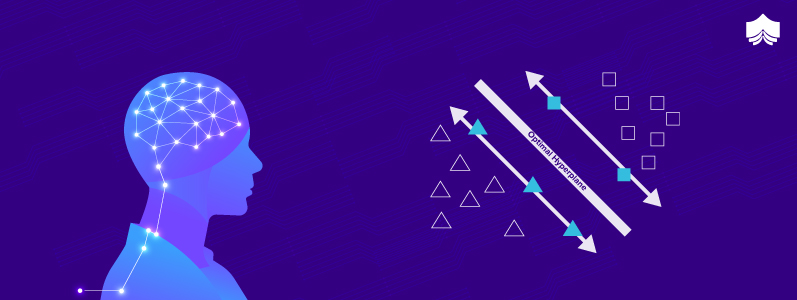

At first glance, support vector machines sound like something you’d find in Tesla’s gigafactory, but they’re anything but that. In this article, we’ll be running through the (mathematical) mechanics of support vector machines, surveying its many applications, and examining the usage of support vector machines in facial recognition technology, along with its ethical considerations. 

# What are support vector machines? 
This section will provide you everything you need to know about SVMs in a quick, but comprehensive manner before we explore how they’re applied in different contexts, especially in facial recognition.

The support vector machine (SVM) is a supervised machine learning algorithm that can perform classification, regression, and outlier detection; however, we'll introduce the SVM with respect to binary classification, where we classify data points between two possible labels. Think of it almost like a yes or no problem! 

The overall premise of the SVM is to create the thickest separating decision slab that optimally separates the different classes of data. SVMs can create decision boundaries of different shapes, but we'll first focus on the linear SVM classifier. More specifically, let's start with hard-margin support vector machines. 

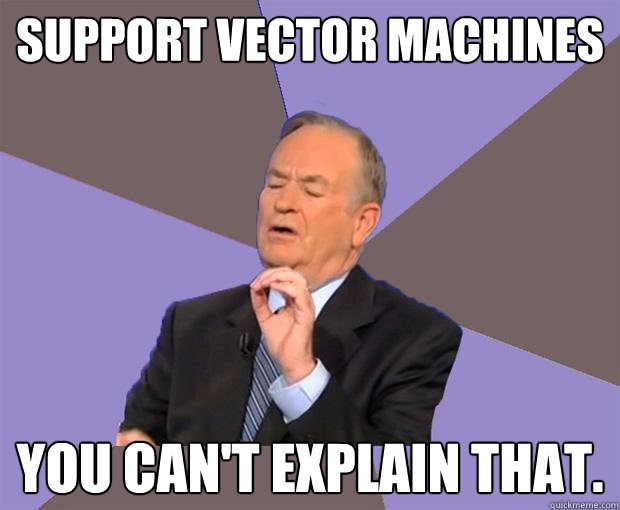

### Hard-margin SVM
Hard-margin SVM and linear SVM classifiers essentially go hand-in-hand. When using hard-margin SVMs, we want to find the widest linear decision boundary that separates the two classes of points. While this can sometimes be easily discerned by our visual cortex, if we wanted to draw a line between the points, there are actually an infinite number of possible lines to draw. That's where SVMs come into play. They determine the hyperplane that optimally separates the data. Think of our decision boundary as a separating slab, centered around a line that cuts through the space separating the classes of points. The visualization below, originally provided by [Samuel S. Watson, PhD](http://www.math.brown.edu/swatson2/index.html), provides visual intuition behind hard-margin SVMs. 

In [1]:
# hide
import Pkg;
Pkg.add("Plots")
Pkg.add("Distributions")
Pkg.add("JuMP")
Pkg.add("Ipopt")
Pkg.add("Random")
Pkg.add("LinearAlgebra")

   Updating registry at `~/.julia/registries/General`
######################################################################### 100.0%
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.t

In [2]:
# hide
using Plots, Distributions, JuMP, Random, LinearAlgebra
gr(fontfamily = "Palatino", size = (400,400), aspect_ratio = 1, legend = false);

In [3]:
# hide
n = 20 
Random.seed!(123)
X = [randn(n) .- 4 randn(n) .+ 4
    randn(n) .+ 3 randn(n)]
y = repeat([1, -1], inner = n)
function original_scatter()
    scatter(X[:, 1], X[:, 2], group=y)
end

original_scatter (generic function with 1 method)

In [4]:
# hide 
(a, b), (c,d) = (-4.0, -2.4), (2.8, 7.7)
function add_line!()
    plot!([(a,b),(c,d)], linewidth = 1.5)
end

add_line! (generic function with 1 method)

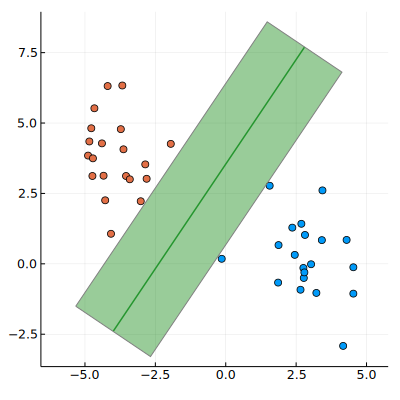

In [5]:
# hide_input
#Pkg.add("LinearAlgebra")
#using LinearAlgebra
function slab(a,b,c,d,w)
    v = [b-d, c-a]
    v *= w/norm(v)
    Tuple.([[a,b] + v, [c,d] + v, [c,d] - v, [a,b] - v, [a,b] + v])
end
function add_slab!()
    plot!(slab(a,b,c,d,1.6), fillopacity = 0.4, seriestype = :shape, fillcolor = :green, linecolor = :gray)
end
original_scatter()
add_line!()
add_slab!()

Mathematically, the slab represents the region between two parallel hyperplanes. The goal is to look for the thickest separating slab and choose the hyperplane in the middle as the decision boundary. Some points reside on the boundaries of the slab. These are **support vectors**, hence the name support vector machine. In essence, points that lie on one side of the slab will be classified as one label, and points that lie on the opposite side will be classified as another. 

Hard-margin SVMs determine the thickest separating slab between classes of points through **constrained optimization**. Suppose our observations are (x,y), where $y$ can assume the value of $+1$ or $-1$. Our separating slab can be described as ${x \in \mathbf{R^2}: -1 \leq \beta'\mathbf{x} + \alpha \leq 1}$, and the total width of the slab is $\frac{2}{|\beta|}$. We can check whether a point is on the correct side by evaluating whether $y_i (\beta \cdot x_i + \alpha) \geq 1$. This is the correct way of checking side membership. Let's say we have a point with label $-1$. If we were to multiply $-1$ by the value of the boundary closest to the cluster of $-1$ points, represented by $\beta \cdot x_i + \alpha = -1$, we'd obtain a positive number. The same principle applies to all $+1$ points.

To obtain the thickest slab, we need to minimize $\beta$, because $\beta$ is in the denominator for our equation for slab width. However, we subject our optimization to the constraint $y_i (\beta \cdot x_i + \alpha) \geq 1$. That is, we're looking for the widest separating slab such that all the points are still on the correct side. These are the general principles of hard-margin SVMs. 

In practice, not all data are so easily separable like the points given in our visualization. Therefore, we need to find a way to determine separating slabs in cases where the data aren't easily separable. Allow me to introduce the soft-margin SVM.

### Soft-margin SVM
Soft-margin SVMs overcome the problem of data inseparability by incurring a penalty term to all misclassified points. This penalty term is included in our loss function, which we will be trying to minimize in our pursuit for a separating slab. 

$$L(\beta,\alpha) = \lambda|\beta|^2 + \frac{1}{n}\sum_{i=1}^n [1 - y_i(\beta \cdot \mathbf{x_i} + \alpha]$$

We penalize by units of slab half-widths. All points on the midline get a penalty of 1 because they're one slab half-width away from the correct boundary, and so on. The parameter $\lambda$ mediates the tradeoff between maximizing slab width and the correcness incentive of the second. Soft-margin SVMs work better than hard-margin SVMs in datasets where points aren't easily separable because misclassified points are actually infinitely penalized in hard-margin SVMs. If we used hard-margin SVM to separate data points that weren't separable, we'd obtain an infinitesimally small separating slab.

### Kernelized SVM
Linear SVM classifiers are but one subset of support vector machines. Kernelized support vector machines allow us to create non-linear decision boundaries to better fit non-linear data. We do this by mapping feature vectors to a higher-dimensional space and finding a hyperplane that separates the data points in that space. For example, we can map data in $\mathbf{R^2}$ to a 3-dimensional space and determine a 2-dimensional hyperplane that separates the data. The image below, brought to you by [Drew Wilimitis](https://towardsdatascience.com/the-kernel-trick-c98cdbcaeb3f), provides an intuitive visualization of what's commonly known as the **kernel trick**. 

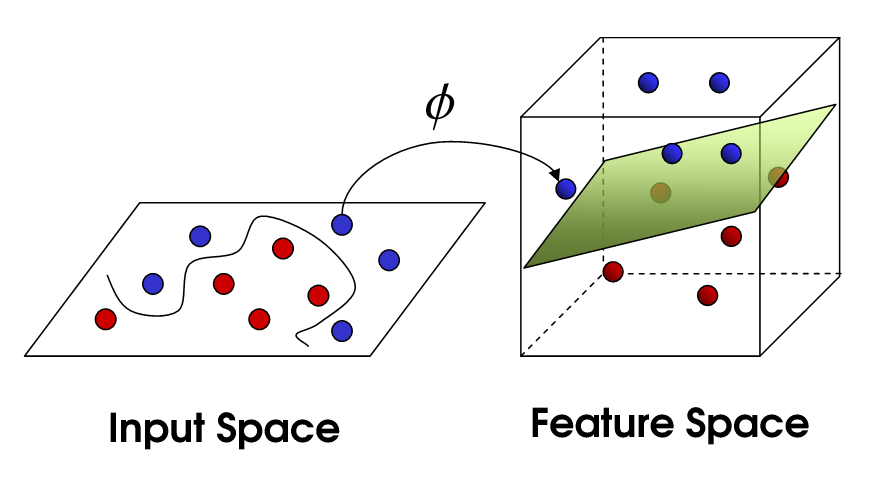

Given the input space, the data appear linearly inseparable, but after mapping through a mapping $\phi$ into a higher-dimensional space, the algorithm could determine a hyperplane that separates the data. The kernel $K$ is actually the dot product between the mappings of $\mathbf{x}$ and $\mathbf{y}$ vectors: $K = (\mathbf{x}, \mathbf{y}) \mapsto \phi(x) \cdot \phi(y)$. Several types are kernels are commonly used in practice, including degree-d polynomial kernels, Gaussian radial basis function kernels, and sigmoid kernels.  

Now that we have the basic principles behind support vectors machines, let's explore some of the applications of SVMs in the real world. 

# Applications of Support Vector Machines
Support vector machines contain extremely desirable characteristics that make it a useful approach to classification problems. For one, they deal well with multi-dimensional data, often because the model returns sparse results and only really depends on a subset of points (the support vectors, et. al). SVMs also return a solution of a maximal margin, and convergence to the minimum for the loss function is guaranteed, given the convex optimization problem that arises when determining our separation slab. Not to mention, several experimental studies have demonstrated better classification accuracy and training times in SVMs, compared to other classification methods. 

The applications for SVMs span far and wide, so let's dive into it! 

### Text-based applications 
Hey Siri, how are SVMs used in text-based applications? Support vector machines are used in a multitude of text-based/speech-based applications, from spam detection, fraud detection, information retrieval for search engines, speech recognition, among many others. SVMs are well-equipped to deal with text/speech data because of the data's high dimensionality and linear separability. Documents of text are typically represented as a vector space with a dimension equal to the number of unique words in text after text preprocessing. 

In a text categorization study on a Reuters data base containing 21,578 documents and 118 categories, support vector machines outperformed Naive Bayes, Bayesian networks, decision trees, and k-nearest neighbors in terms of classification accuracy.

### Bioinformatics 
With the advent of the Human Genome Project, biological data has faced an explosion in growth and availability. From genetic data to neurological data, the life sciences industry has had more data at their disposal than ever before. Ever since, there has been great interest in analysing biological samples using gene expression profiles. Some use cases for support vector machines include tissue classification, gene function prediction, protein secondary structure prediction, and protein fold prediction. An especially relevant application in bioinformatics is cancer recognition. These use cases are applicable to numerous subfields within the life sciences, from drug development to forensics. Many of these applications rely on methods used on image-based and text-based data, but they remain extremely important to life science research and healthcare. 

### Geospatial data
SVMs are solid candidates for classification and prediction problems using geospatial data. Problems range from the calculation of the planets' density, to weather predictions. Geospatial data, especially electromagnetic data, are noisy and delicate. Points appear quite close to one another, so the data must utilize a method that prevents overfitting. Support vector machines are used to handle these datasets for this reason. 

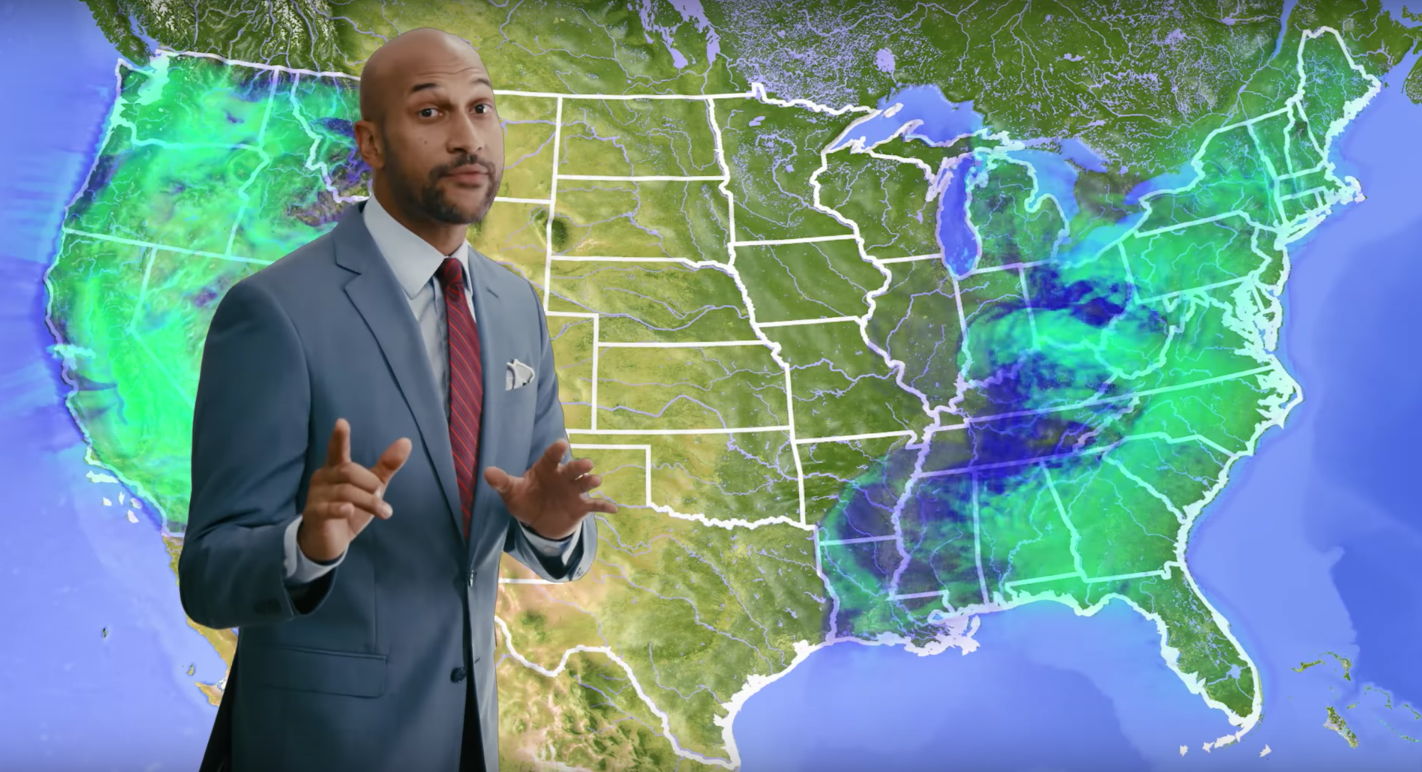

These applications cover but the tip of the iceberg of possible applications of support vector machines. Although SVMs have been around since the late-20th century, it's no surprise that their usage is so broad. Support vector machines are incredibly versatile and reliable; one could be sure it'll *support* (nervous laughter) your supervised machine learning pipeline, if used correctly. 

Next, we'll be placing special attention to facial recognition technology, a technology that's had an incredibly broad impact in all corners of the world. Ubiquitous in today's society, we'll explore how facial recognition was first developed with SVMs and how it's evolved up until today. Facial recognition has not been without its fair share of controversy, so we'll be considering the ethical considerations of facial recognition technology as well. 

# Facial Recognition Technology
Have you ever wondered how Facebook could recognize your face in your mother's annual Christmas Facebook post? Ever wonder how your photos could be sorted by face? Ever thought about how Snapchat recognizes where to apply its filters? The answers lie in facial recognition technology. Interestingly enough, support vector machines were one of the most reliable methods for facial recognition and paved the way for modern facial recognition technology. 

### so... how do SVMs recognize faces?
Early research in facial recognition technology was concerned with two core problem subtypes: verification and identification. Facial recognition is a K-class problem, where $K$ represents the number of known individuals. SVMs are binary classifiers. Most image databases contain a large number of individuals but few images per person. Not to mention, our algorithms must also successfully learn how to extrapolate information from limited training data. Now, how could we reinterpret a K-class problem to be suitable for binary classifiers? The National Institute of Standards and Technology (NIST) describes a method to reinterpret support vector machines to be transferrable to facial recognition. 

To convert facial recognition into a binary classification problem, we operate on a **difference space**. A difference space is interested in two classes, the dissimilarities between images of the same person (within-subject differences) and dissimilarities between images of different people (between-subjects differences). Once the difference spaces have been constructed, we can then develop similarity metrics and decision surfaces that separate the two classes. Bear in mind that images are also stored as vectors in $\mathbf{R^n}$ and make up a **face space**. 

Let's say we're trying to verify a person's identity using facial recognition. Usually, a verification algorithm is presented with an image $p$ and a claimed identity stored in a facial image database. This is a binary classification problem because we have two possibilities; the person's claim for identity is either accepted or rejected. We first construct a classifier for a person $X$ by feeding a training set with images of one person and another set with images of other people. From this information, a linear decision surface is created to separate the images of the person from the other people. The identity of a face in image $p$ is accepted if $w \cdot p + b \leq 0$, where $w$ represents the sum of the products of all support vectors, coefficients, and class labels (usually denoted $\pm 1$), and $b$ a constant term.

However, there's the possibility of false positives, so we parameterize the decision surface by a value $\Delta$. Thus, the identity of image $p$ is accepted if $w \cdot p + b \leq \Delta$. The parameter $\Delta$ mediates the tradeoff between true positive and false positive rates. 

Similar mechanics are applied in identification problems, where a similarity score is evaluated by $\Delta \cdot (p_1 - p_2) + b$, where $p_1$ and $p_2$ are two images being compared to one another. 

Solutions to verification and identification, as detailed above, are not limited to linear SVM classifiers. In fact, kernelized SVMs demonstrate the greatest performance and training time compared to other classification methods in early studies. The image below also presents the general workflow that underly basic facial recognition algorithms. To learn more, the original paper from the NIST can be found [here](https://papers.nips.cc/paper/1998/file/a2cc63e065705fe938a4dda49092966f-Paper.pdf)!

Facial recognition algorithms have largely evolved since the 90s, when SVMs were used in facial recognition tech. Much of the facial recognition literature today focuses on Deep Convolutional Neural Networks, which are currently deployed in facial recognition algorithms at companies like Google, Facebook, and Microsoft. Rather on relying the similarities/differences, feature extraction algorithms extract key features on a person's face and calculate those features into a vector of values relating to the person's identity. Learn more about DCNNs in facial recognition [here](https://arxiv.org/pdf/1907.12739.pdf)!

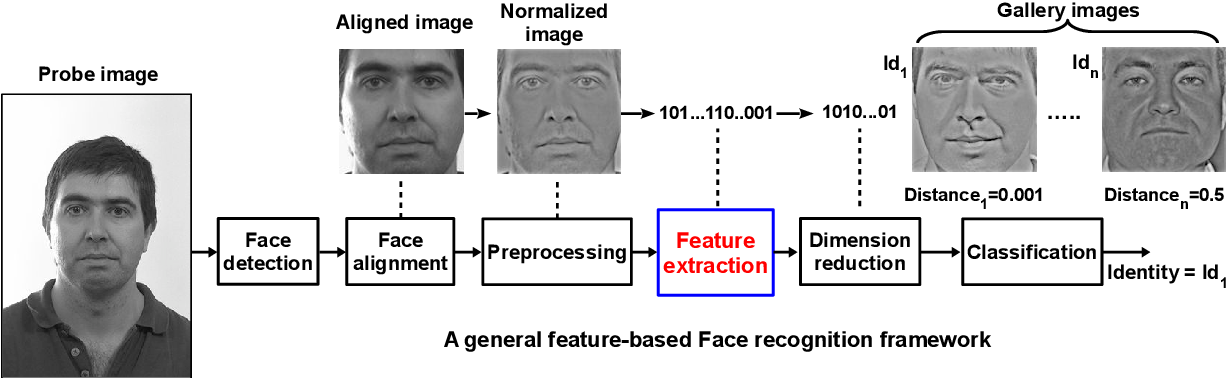

### Beyond ID and Verification
Though a less popular field of facial recognition technology research than identification and verification, early research has studied support vector machines' abilities to classify gender and ethnicity given facial image data. 

In 2002, Baback Moghaddam and Ming-Hsuan Yang published a [paper](https://www.merl.com/publications/docs/TR2002-12.pdf) on the capabilities of nonlinear SVMs for appearance-based gender classification and developed robust algorithms that only demonstrate a 1% performance differential in low-resolution and high-resolution images. They classified one's gender by checking the sign of a scalar output $f(x)$. If positive, the face could be classified as female, and vice versa. Interestingly, the classifiers developed by Moghaddam and Yang had higher error ra tes for classifying females than males. Their explanation was that this was most likely due to the lack of prominent facial features in female faces. Although this paper was published in the early 21st century, this implementation could be deemed non-inclusive to those who identify as non-binary and to those who've undergone a switch in gender. Much remains to be studied about how modern gender recognition algorithms can be modified to accommodate these populations. 


A paper studying ethnic classification using a gamut of classification techniques, including SVMs was published in 2010 by [Toderici et. al (2010)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.456.6905&rep=rep1&type=pdf). The studies ignore skin tone and rely on the discriminative power of facial structure alone. However, only Asian and White samples were considered for ethnic classification because other groups contained far too few participants to support meaningful results. 

As we transition to the ethical considerations of facial recognition technologies, we will find that seemingly trivial shortcomings to studies like these can have meaningful real-world implications. 

# Ethical Considerations
While facial recognition technology has allowed for advancements in numerous sectors, its usage by corporations and governments has been the subject for controversy since it's made its way into the mainstream. Many ethical questions relating to user privacy and security have been raised over facial recognition technology, and hallmark lawsuits and studies have stirred general skepticism of the technology. We'll consider a number of concerns looming over facial recognition technology. 

### Demographic Biases in Facial Recognition
A landmark [study](https://nvlpubs.nist.gov/nistpubs/ir/2019/NIST.IR.8280.pdf) from the NIST in 2019 outlined the differences in performance with relation to ethnic and gender classification. This study conducted a number of tests aimed to determine whether and to what extent facial recognition algorithms differed when they processed photographs of individuals from various demographics and place special attention on false positives and negatives. As a government institute, the NIST tested their claims using application photos, ID photos, and domestic law enforcement photos. 

Some key results in the study found a high false positive rate in West/East African and East Asian people among application photos, and a low false positive rate among Eastern European application photos. In domestic law enforcement photos, the NIST documented high false positives in American Indians and elevated rates in African American and Asian populations. 

The study compared performance between gender and age groups as well. Higher false positive rates occurred in female photos than male photos, and this was consistent across algorithms and datasets. False positive rates were also elevated in the elderly and children. Having high false positive rates are a major security concern, as we'll see in the following section. 

If you'd like to learn more about algorithmic bias in facial recognition and beyond, I highly encourage you to check out [Joy Buolamwini](https://www.media.mit.edu/people/joyab/overview/) of MIT!

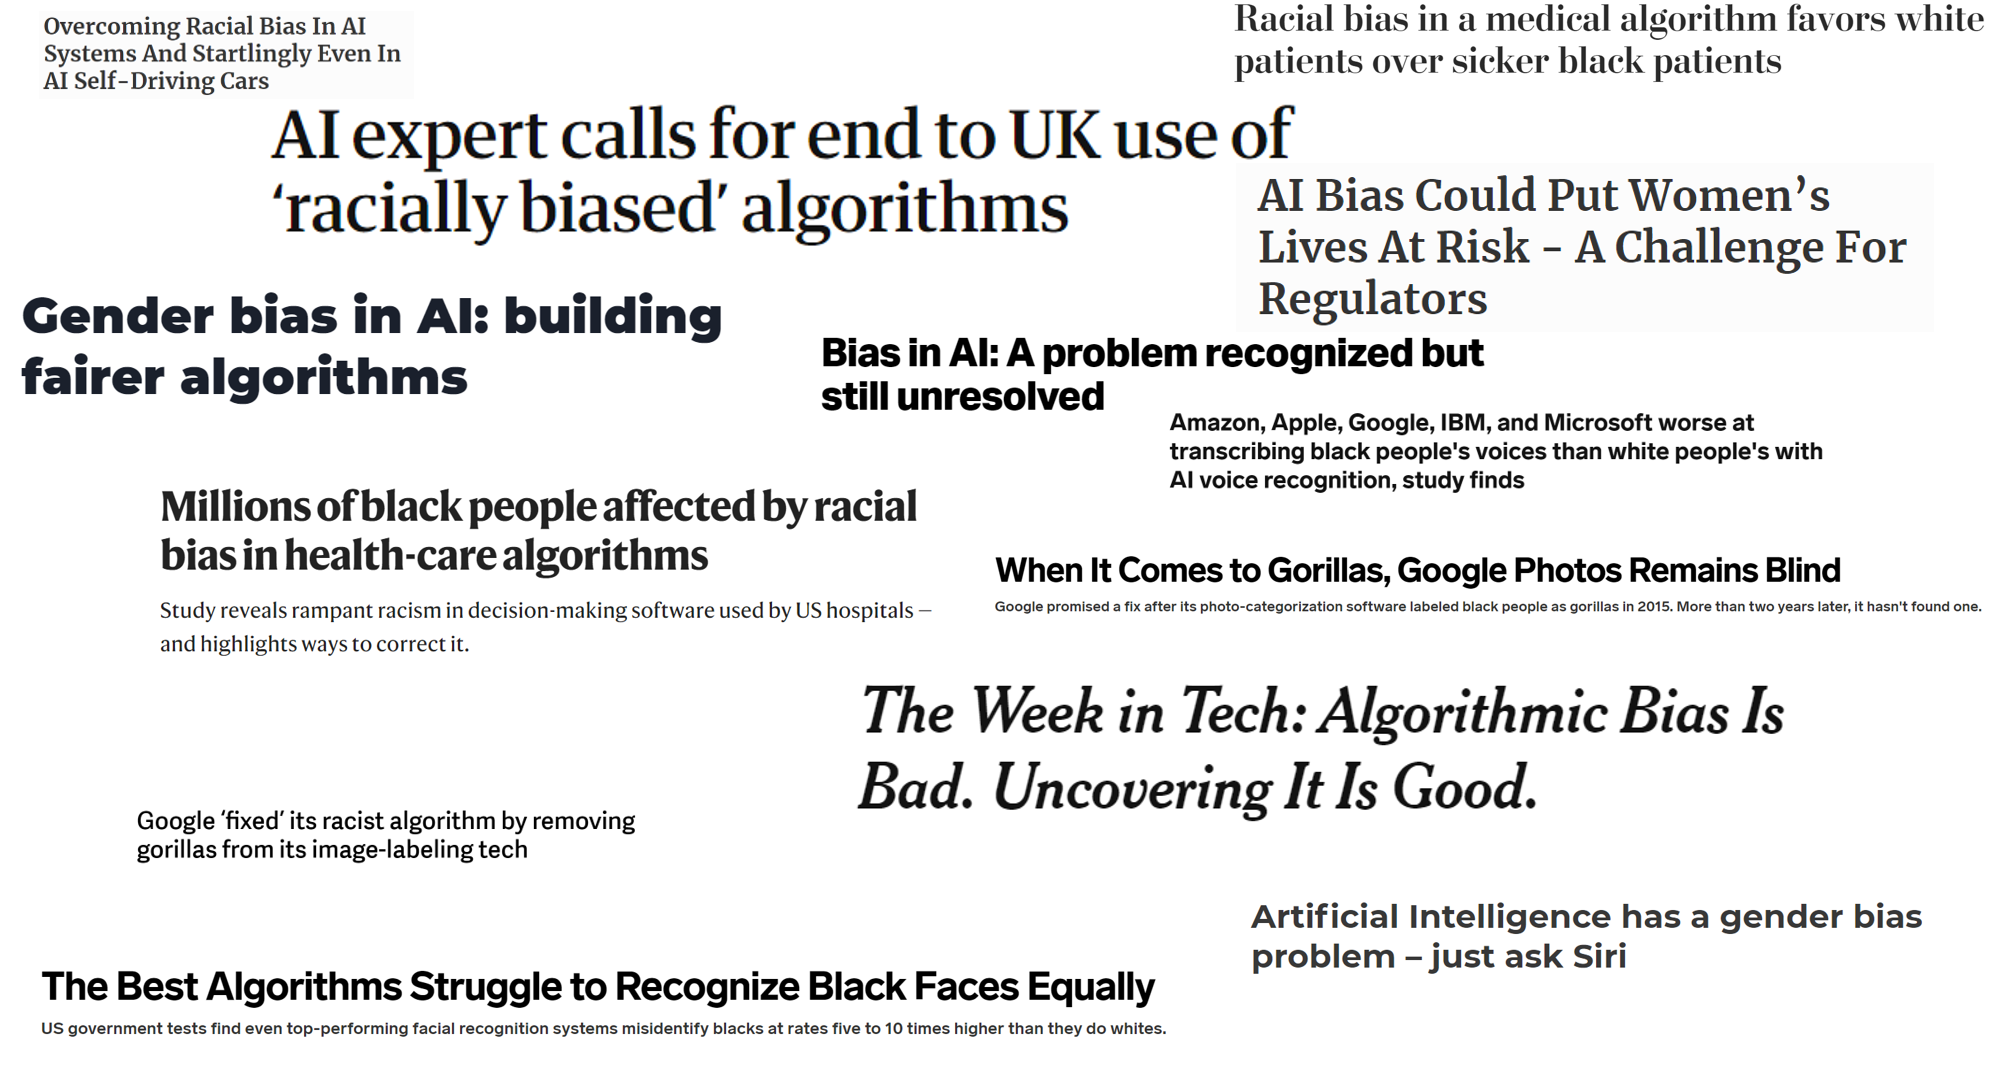

### Security/Privacy Concerns
Government agencies and corporations store enormous databases of facial images and biometric data, sometimes contains information linked to millions of identities. While biometric data has demonstrated advantageous properties for security on some fronts,  a security breach could thoroughly affect millions of lives, if one were to occur on these databases. Security could also be a concerned on an individual scale as well. Remember the false positive rates discussed in the previous section? False positives suggest that imposters could access your confidential information, and the probability of this occurring is disproportionately higher in some demographics. [Deepfake technology](https://spectrum.ieee.org/tech-talk/computing/software/what-are-deepfakes-how-are-they-created) provides a source of concern on this front. Below is a deepfake of Barack Obama, brought to you by openDemocracy. 

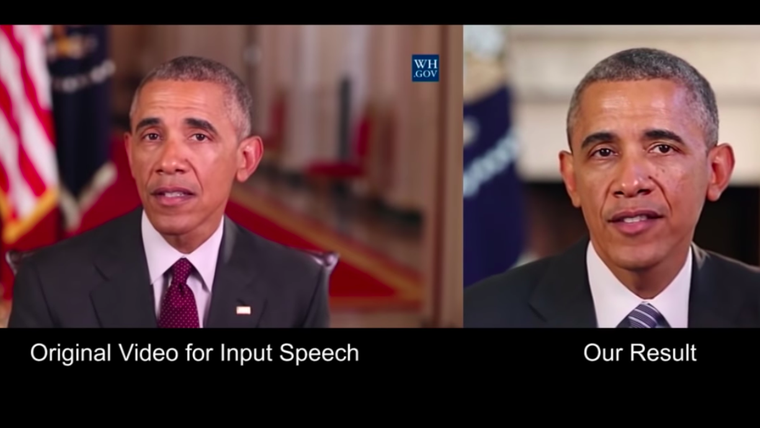

There are also concerns about the lack of federal regulations surrounding facial recognition technology, leaving potential for abuse by governing bodies, like law enforcement. With facial recognition technologies becoming a focal part of policing around the world, citizens face the threat of constant of surveillance by law enforcement. Also, growing reliance on facial recognition technology can lead to misidentification of criminals and wrongful arrests/imprisonment. 

Some states have take measures to address privacy concerns with respect to law enforcement. Oregon and New Hampshire banned facial recognition technologies embedded in body cameras, and cities including San Francisco and Oakland have banned certain usages of facial recognition in law enforcement. The state of Illinois recently forced a 650 million dollar settlement from Facebook after the social media giant had violated their Biometric Information Privacy Act, which requires institutions to gain consent before collecting biometric data. Now, Facebook allows users to opt out of their facial recognition technology. 

Ultimately, the issues taking the spotlight all boil down to several factors: where facial image data is stored, how it's protected and used, and the policies in place meant to protect its constituents. Corporations, agencies, and policy makers alike will have to finetune the balance between these factors in order to create trustworthy, equitable, and reliable facial recognition systems. 

# Well, that was a lot. 
Despite the ethical concerns behind facial recognition technology, which was pioneered using support vector machines, let's not forget about SVMs' other applications, which all have potential to change the world. Though they've been around for some time, don't be surprised if you see SVMs being applied in new and innovative ways. 

Support vector machines are geared to find decision boundaries between classes of data with optimality. With high solution margins and propensity to resist overfitting, the support vector machine is an incredibly reliable method for classifying data points in a feature space. Thanks for reading. I hope you enjoyed it :-)